# Noise correction between events
Using the calibration baseflow levels al reference, and find a scaling factor for the other events

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram
from scipy.ndimage import gaussian_filter1d

# function definition
def gain_compensation(data, gain):
    linear_gain = 10 ** (gain / 20)
    calibrated_data = data / linear_gain
    return calibrated_data

def compute_rms(folder, channel, gain_db):
    """
    folder : str (Path to the folder containing .flac recordings)
    channel : str (Channel to use: 'left' or 'right')
    gain_db : float (Gain value (in dB) used in the field for the selected channel)
    -------
    Returns a DataFrame with columns ['filename', 'rms', 'rms_dB', 'date_str'].
    """
    results = []
    for filename in os.listdir(folder):
        if filename.endswith(".flac"):
            filepath = os.path.join(folder, filename)
            data, samplerate = sf.read(filepath)

            # select the channel from input
            if data.ndim == 2:
                if channel.lower() == "left":
                    data = data[:, 0]
                elif channel.lower() == "right":
                    data = data[:, 1]
                else:
                    raise ValueError("must be 'left' or 'right'.")

            # apply gain compensation
            data = gain_compensation(data, gain_db)

            # compute RMS amplitude
            rms = np.sqrt(np.mean(data ** 2))
            rms_db = 20 * np.log10(rms)

            # extract datetime info from filename (e.g., raspberrypi_072321-081600)
            try:
                date_str = filename.split("_")[1].split(".")[0]
            except:
                date_str = filename

            results.append({
                "filename": filename,
                "rms": rms,
                "rms_dB": rms_db,
                "date_str": date_str
            })
    noise_df = pd.DataFrame(results)
    return noise_df

### Import discharge data

In [3]:
# import shear stress data, making first column date_time and the index
tau_2021 = pd.read_csv('../mobile_shear_stress_2021.csv', index_col=0, parse_dates=True)
tau_2022 = pd.read_csv('../mobile_shear_stress_2022.csv', index_col=0, parse_dates=True)
tau_2023 = pd.read_csv('../mobile_shear_stress_2023.csv', index_col=0, parse_dates=True)
# give the second column a name
tau_2021.columns = ['tau']
tau_2022.columns = ['tau']
tau_2023.columns = ['tau']

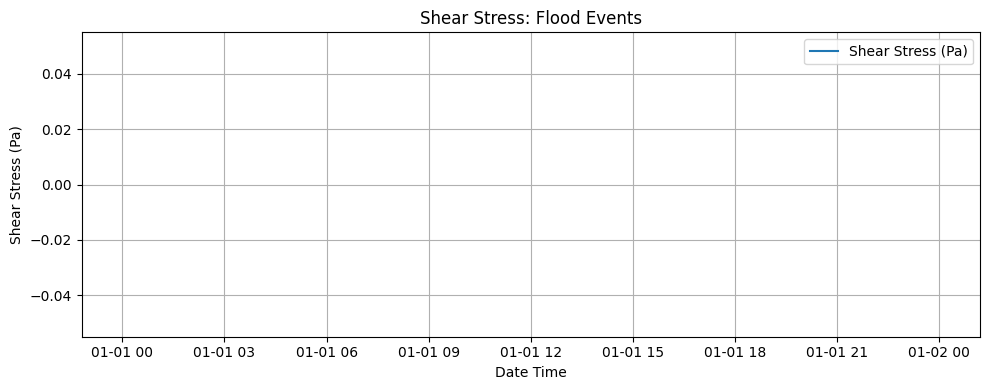

In [4]:
# get dicharges during the flood events (baseflow)
tau_floods = tau_2023.loc['2023-09-20':'2023-09-21']
# plot shear stress during flood events
plt.figure(figsize=(10, 4))
plt.plot(tau_floods.index, tau_floods['tau'], label='Shear Stress (Pa)')
plt.xlabel('Date Time')     
plt.ylabel('Shear Stress (Pa)')
plt.title('Shear Stress: Flood Events')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Merge with your discharge dataframe (assuming it has a matching datetime column)
# discharge_df = pd.read_csv("discharge_data.csv")
# merged_df = pd.merge(noise_df, discharge_df, on="date_str", how="left")